# PhysioNet Dataset Preprocessing

This notebook focuses on preprocessing the PhysioNet dataset, which contains time series data of patient vital signs and laboratory measurements. The dataset is part of the PhysioNet Computing in Cardiology Challenge 2019, focusing on early prediction of sepsis.

## Dataset Overview
- Time series data with hourly measurements
- Multiple vital signs and lab values
- Binary classification task (sepsis prediction)

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Set plotting style safely using seaborn API with matplotlib fallback
try:
    sns.set_style('whitegrid')
    sns.set_palette('viridis')
except Exception:
    # Fall back to matplotlib default if seaborn isn't available or style fails
    try:
        plt.style.use('default')
    except Exception:
        pass

# Small helper: safe plotting wrappers (use these in subsequent EDA cells)
def safe_countplot(df, col, title=None, figsize=(8, 6)):
    col_found = None
    if col in df.columns:
        col_found = col
    else:
        # case-insensitive search
        lower_map = {c.lower(): c for c in df.columns}
        if col.lower() in lower_map:
            col_found = lower_map[col.lower()]

    if col_found is None:
        print(f"Skipping plot: column '{col}' not found (available: {list(df.columns)[:10]}...)")
        return

    plt.figure(figsize=figsize)
    sns.countplot(x=col_found, data=df)
    if title:
        plt.title(title)
    plt.show()


def safe_histplot(df, col, title=None, bins=30, figsize=(8, 6)):
    col_found = None
    if col in df.columns:
        col_found = col
    else:
        lower_map = {c.lower(): c for c in df.columns}
        if col.lower() in lower_map:
            col_found = lower_map[col.lower()]

    if col_found is None:
        print(f"Skipping histogram: column '{col}' not found (available: {list(df.columns)[:10]}...)")
        return

    plt.figure(figsize=figsize)
    sns.histplot(df[col_found].dropna(), bins=bins)
    if title:
        plt.title(title)
    plt.show()

## 1. Load and Explore Dataset

In [3]:
# Define paths
base_path = '../PhysioNet/'
training_path = os.path.join(base_path, 'training')
dataset_info = pd.read_csv(os.path.join(base_path, 'Dataset.csv'))

# Display dataset info
print(f"Dataset shape: {dataset_info.shape}")
dataset_info.head()

Dataset shape: (1552210, 44)


,Unnamed: 0,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,1,0,17072
1,1,1,65.0,100.0,NaN,NaN,72.0,NaN,16.5,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,2,0,17072
2,2,2,78.0,100.0,NaN,NaN,42.5,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,3,0,17072
3,3,3,73.0,100.0,NaN,NaN,NaN,NaN,17.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,4,0,17072
4,4,4,70.0,100.0,NaN,129.0,74.0,69.0,14.0,NaN,...,NaN,330.0,68.54,0,NaN,NaN,-0.02,5,0,17072


In [4]:
# Load a sample patient file to understand structure
sample_file = os.path.join(training_path, 'p000001.psv')
sample_data = pd.read_csv(sample_file, sep='|')

print(f"Sample patient data shape: {sample_data.shape}")
sample_data.head()

Sample patient data shape: (54, 41)


,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,1,0
1,97.0,95.0,NaN,98.0,75.33,NaN,19.0,NaN,NaN,NaN,...,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,2,0
2,89.0,99.0,NaN,122.0,86.00,NaN,22.0,NaN,NaN,NaN,...,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,3,0
3,90.0,95.0,NaN,NaN,NaN,NaN,30.0,NaN,24.0,NaN,...,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,4,0
4,103.0,88.5,NaN,122.0,91.33,NaN,24.5,NaN,NaN,NaN,...,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,5,0


In [5]:
# Get column information
columns = sample_data.columns.tolist()
print(f"Number of features: {len(columns)}")
print("Features:")
print(columns)

Number of features: 41
Features:
['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS', 'SepsisLabel']


## 2. Load All Patient Data

In [6]:
def load_patient_data(file_path):
    """Load a single patient file and add patient ID"""
    patient_id = os.path.basename(file_path).split('.')[0]
    data = pd.read_csv(file_path, sep='|')
    data['patient_id'] = patient_id
    return data

# Get list of all patient files
patient_files = [os.path.join(training_path, f) for f in os.listdir(training_path) if f.endswith('.psv')]
print(f"Total number of patient files: {len(patient_files)}")

# Load a subset of patients for development (to avoid memory issues)
# For full processing, remove the slicing
sample_size = 100  # Adjust based on your system's memory
patient_files_sample = patient_files[:sample_size]

# Load patient data
print(f"Loading {len(patient_files_sample)} patient files...")
all_patient_data = []
for file in tqdm(patient_files_sample):
    patient_data = load_patient_data(file)
    all_patient_data.append(patient_data)

# Combine all patient data
combined_data = pd.concat(all_patient_data, ignore_index=True)
print(f"Combined data shape: {combined_data.shape}")

Total number of patient files: 20336
Loading 100 patient files...


100%|██████████| 100/100 [00:02<00:00, 36.06it/s]

Combined data shape: (3704, 42)


## 3. Exploratory Data Analysis

In [7]:
# Check basic statistics
combined_data.describe().T

,count,mean,std,min,25%,50%,75%,max
HR,3402.0,89.689888,17.550979,44.50,76.500,89.00,102.000,155.50
O2Sat,3236.0,97.281057,2.426899,79.00,96.000,98.00,99.000,100.00
Temp,1229.0,37.077917,0.873990,33.22,36.500,37.06,37.670,40.50
SBP,3058.0,121.685033,20.495106,69.00,106.000,120.00,136.000,220.50
MAP,3315.0,79.482365,14.057671,20.00,69.835,78.00,88.000,219.00
DBP,1719.0,61.899651,13.601167,32.00,53.000,60.00,69.000,287.00
Resp,3319.0,19.158406,5.630220,4.00,15.000,18.00,22.000,55.50
EtCO2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BaseExcess,371.0,-0.291105,5.410465,-14.00,-3.000,0.00,2.000,24.00
HCO3,307.0,23.845277,4.821961,12.00,21.000,23.00,26.000,48.00


In [8]:
# Check missing values
missing_values = combined_data.isna().sum().sort_values(ascending=False)
missing_percent = (missing_values / len(combined_data)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percent Missing': missing_percent
})

missing_df.head(20)

,Missing Values,Percent Missing
EtCO2,3704,100.000000
Bilirubin_direct,3700,99.892009
TroponinI,3700,99.892009
Fibrinogen,3679,99.325054
Bilirubin_total,3655,98.677106
Alkalinephos,3645,98.407127
AST,3641,98.299136
Lactate,3569,96.355292
SaO2,3557,96.031317
PTT,3536,95.464363


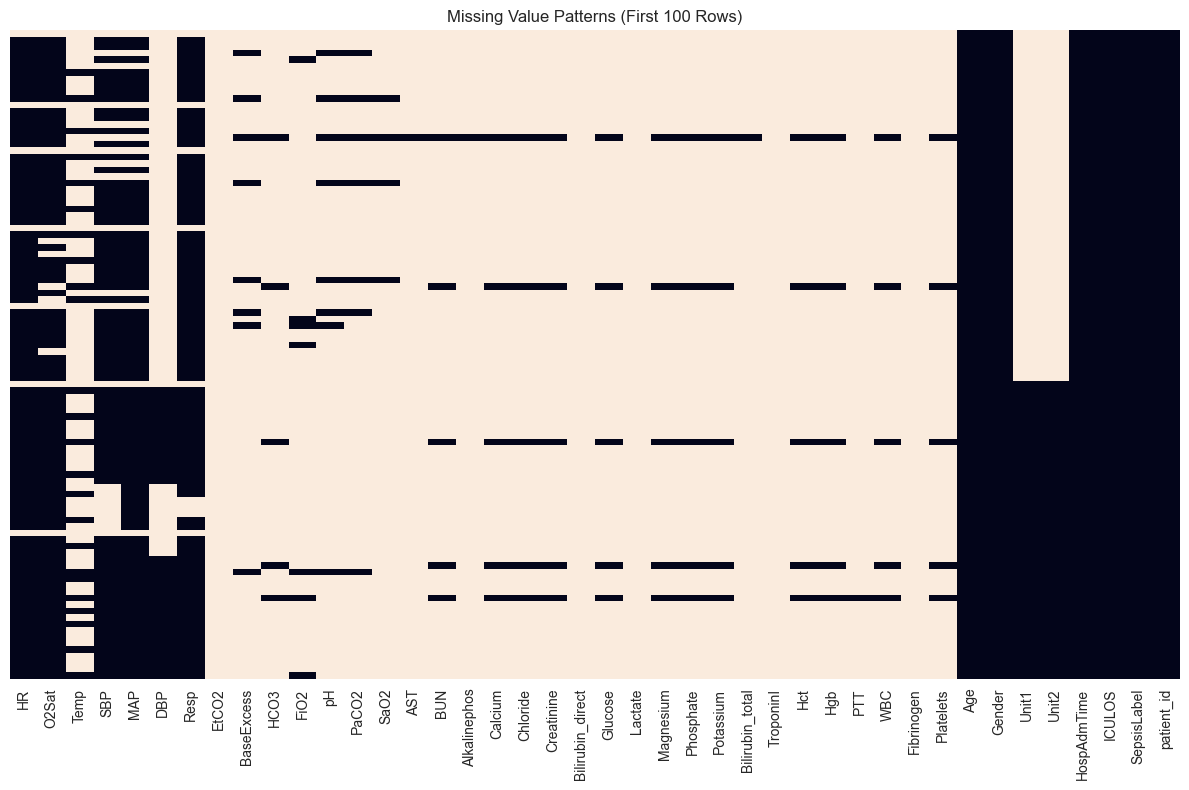

In [9]:
# Visualize missing values
plt.figure(figsize=(12, 8))
sns.heatmap(combined_data.iloc[:100].isna(), cbar=False, yticklabels=False)
plt.title('Missing Value Patterns (First 100 Rows)')
plt.tight_layout()
plt.show()

Sepsis Label Distribution:
SepsisLabel
0    3569
1     135
Name: count, dtype: int64
Percentage of sepsis cases: 3.64%


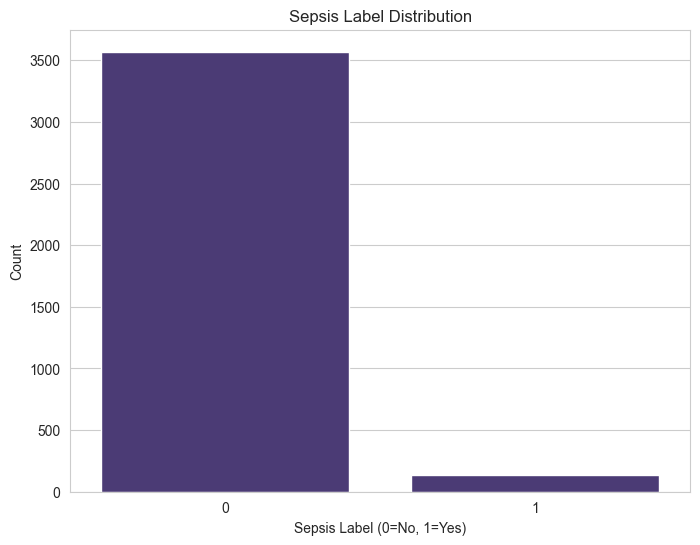

In [10]:
# Check sepsis distribution
sepsis_counts = combined_data['SepsisLabel'].value_counts()
print("Sepsis Label Distribution:")
print(sepsis_counts)
print(f"Percentage of sepsis cases: {sepsis_counts[1] / len(combined_data) * 100:.2f}%")

# Visualize sepsis distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='SepsisLabel', data=combined_data)
plt.title('Sepsis Label Distribution')
plt.xlabel('Sepsis Label (0=No, 1=Yes)')
plt.ylabel('Count')
plt.show()

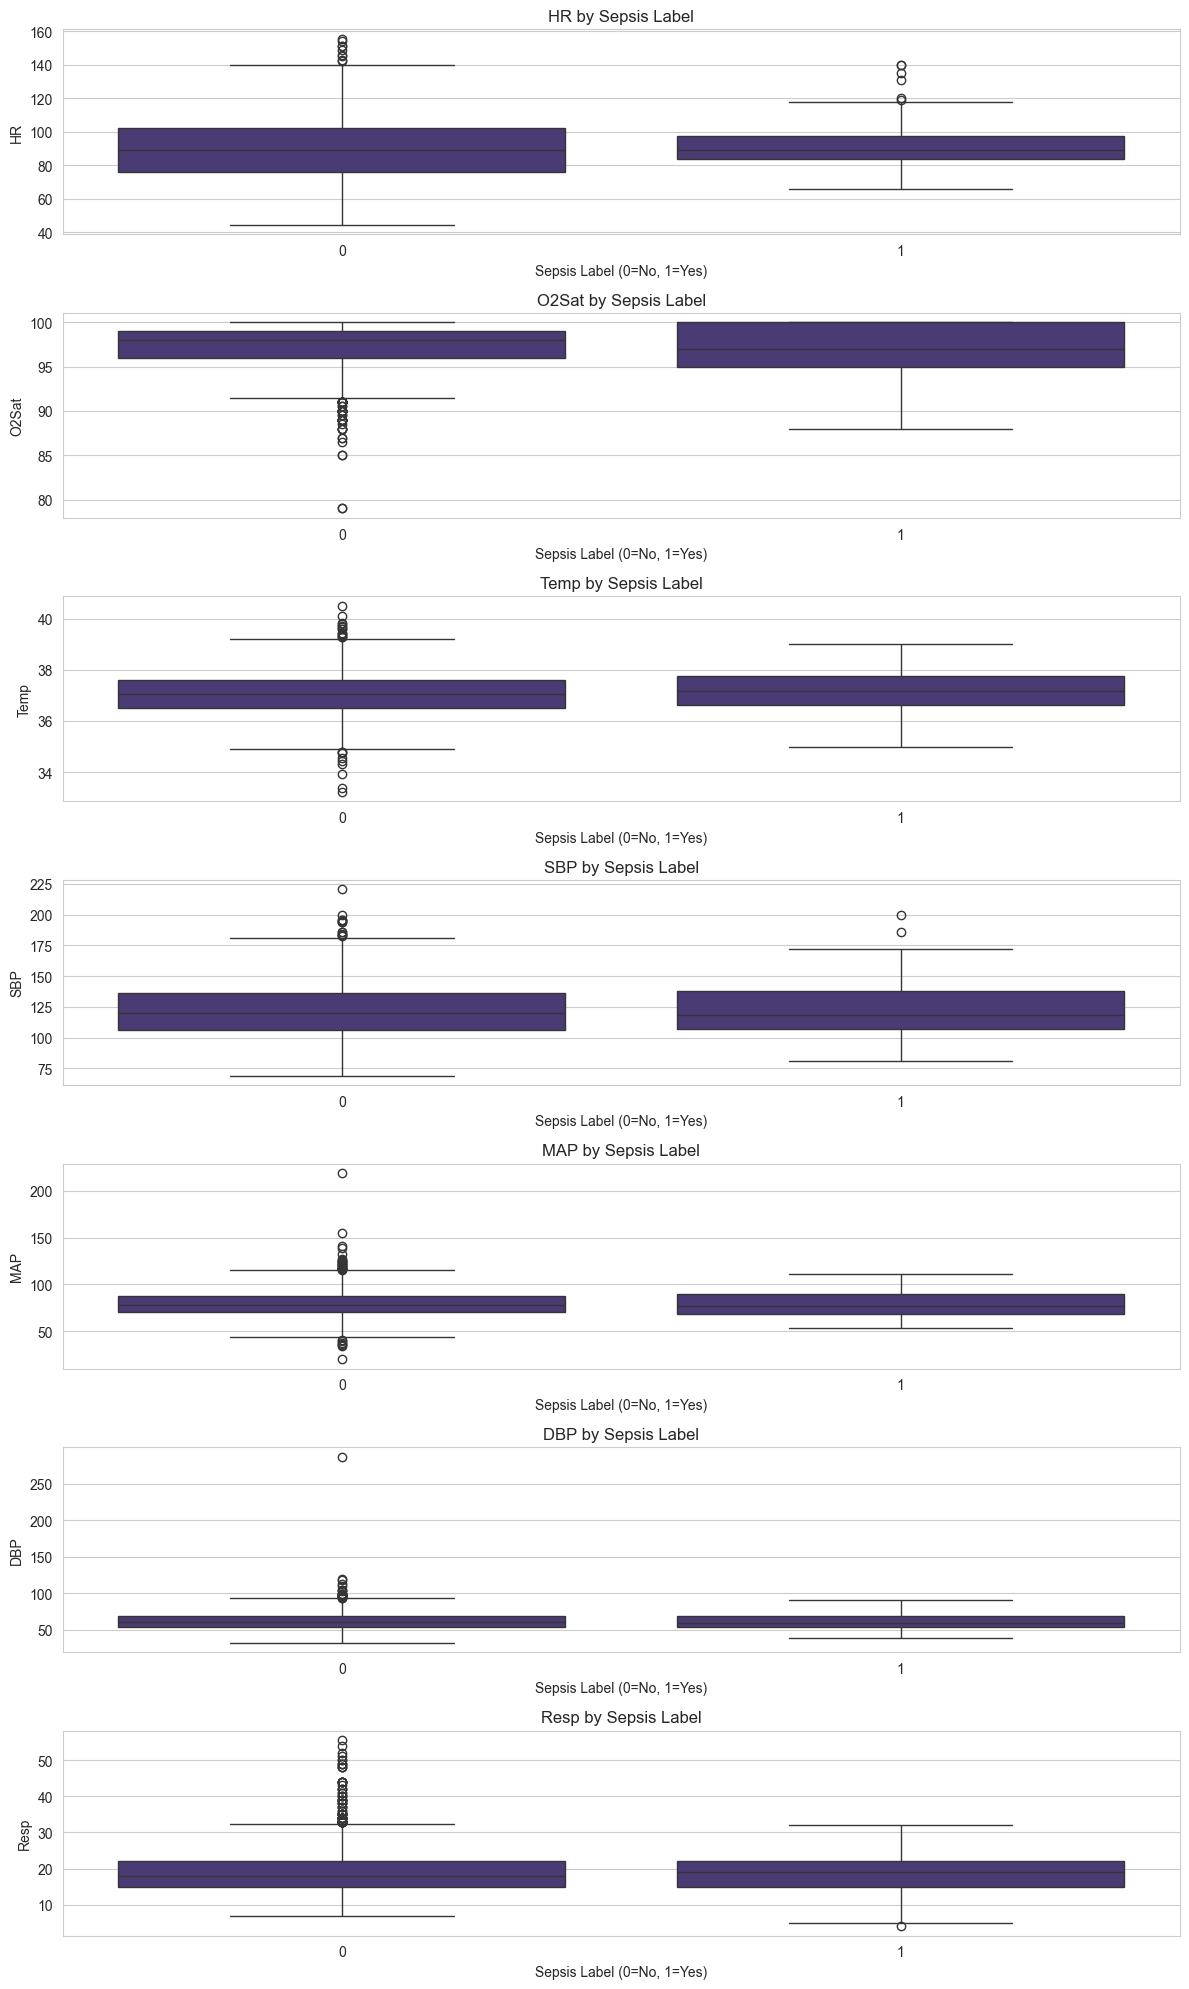

In [11]:
# Analyze vital signs for sepsis vs non-sepsis patients
vital_signs = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp']

fig, axes = plt.subplots(len(vital_signs), 1, figsize=(12, 20))
for i, vital in enumerate(vital_signs):
    sns.boxplot(x='SepsisLabel', y=vital, data=combined_data, ax=axes[i])
    axes[i].set_title(f'{vital} by Sepsis Label')
    axes[i].set_xlabel('Sepsis Label (0=No, 1=Yes)')
    
plt.tight_layout()
plt.show()

## 4. Data Preprocessing

Average sequence length: 37.04 hours
Min sequence length: 8 hours
Max sequence length: 258 hours


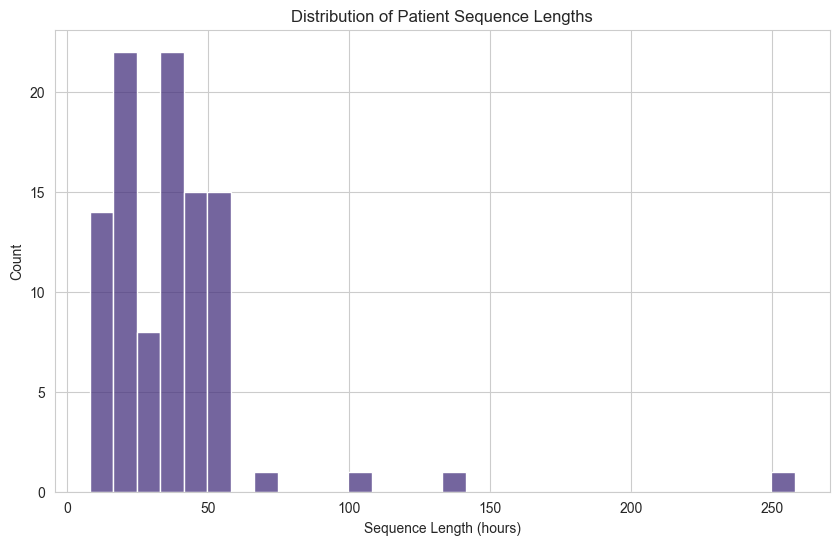

In [12]:
# Group data by patient
patient_groups = combined_data.groupby('patient_id')

# Check sequence lengths
sequence_lengths = patient_groups.size()
print(f"Average sequence length: {sequence_lengths.mean():.2f} hours")
print(f"Min sequence length: {sequence_lengths.min()} hours")
print(f"Max sequence length: {sequence_lengths.max()} hours")

# Plot sequence length distribution
plt.figure(figsize=(10, 6))
sns.histplot(sequence_lengths, bins=30)
plt.title('Distribution of Patient Sequence Lengths')
plt.xlabel('Sequence Length (hours)')
plt.ylabel('Count')
plt.show()

In [13]:
# Identify key vital signs and lab values with less missing data
key_features = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 
                'Glucose', 'Potassium', 'Hct', 'Hgb', 'WBC', 'Platelets']

# Calculate missing percentage for key features
key_missing = missing_df.loc[key_features]
key_missing.sort_values('Percent Missing')

,Missing Values,Percent Missing
HR,302,8.153348
Resp,385,10.394168
MAP,389,10.502160
O2Sat,468,12.634989
SBP,646,17.440605
DBP,1985,53.590713
Temp,2475,66.819654
Glucose,3261,88.039957
Potassium,3289,88.795896
Hct,3306,89.254860


## 5. Feature Engineering

In [14]:
def engineer_features_for_patient(patient_data):
    """Engineer features for a single patient"""
    # Create a copy to avoid modifying the original data
    data = patient_data.copy()
    
    # Calculate rolling statistics for vital signs (6-hour windows)
    for feature in key_features:
        if feature in data.columns:
            # Rolling mean
            data[f'{feature}_rolling_mean_6h'] = data[feature].rolling(window=6, min_periods=1).mean()
            # Rolling std
            data[f'{feature}_rolling_std_6h'] = data[feature].rolling(window=6, min_periods=1).std()
            # Rolling min/max
            data[f'{feature}_rolling_min_6h'] = data[feature].rolling(window=6, min_periods=1).min()
            data[f'{feature}_rolling_max_6h'] = data[feature].rolling(window=6, min_periods=1).max()
    
    # Calculate rate of change for key vitals
    for feature in ['HR', 'SBP', 'Temp', 'Resp']:
        if feature in data.columns:
            data[f'{feature}_change'] = data[feature].diff()
    
    # Create shock index (HR/SBP ratio) - useful for sepsis detection
    if 'HR' in data.columns and 'SBP' in data.columns:
        data['shock_index'] = data['HR'] / data['SBP']
    
    # Create modified shock index (HR/MAP ratio)
    if 'HR' in data.columns and 'MAP' in data.columns:
        data['modified_shock_index'] = data['HR'] / data['MAP']
    
    return data

# Apply feature engineering to each patient
print("Engineering features for each patient...")
engineered_data = []
for name, group in tqdm(patient_groups):
    engineered_patient = engineer_features_for_patient(group)
    engineered_data.append(engineered_patient)

# Combine all engineered data
engineered_combined = pd.concat(engineered_data, ignore_index=True)
print(f"Engineered data shape: {engineered_combined.shape}")

Engineering features for each patient...


100%|██████████| 100/100 [00:04<00:00, 21.97it/s]


Engineered data shape: (3704, 100)


## 6. Handle Missing Values

In [15]:
# Select features for modeling
# Include original features and engineered features
selected_features = key_features + [
    col for col in engineered_combined.columns 
    if ('rolling' in col or 'change' in col or 'shock' in col) and 'NaN' not in col
]

# Add demographic features
selected_features += ['Age', 'Gender', 'ICULOS']

# Create modeling dataset
modeling_data = engineered_combined[selected_features + ['SepsisLabel', 'patient_id']]
print(f"Modeling data shape: {modeling_data.shape}")
print(f"Number of features: {len(selected_features)}")

Modeling data shape: (3704, 76)
Number of features: 74


In [17]:
# Handle missing values using forward fill within each patient
print("Handling missing values...")
imputed_data = []

for name, group in tqdm(modeling_data.groupby('patient_id')):
    # Work on a copy to safely modify
    imputed_group = group.copy()

    # Forward fill (use previous values)
    imputed_group = imputed_group.ffill()

    # For any remaining NaNs, use backward fill
    imputed_group = imputed_group.bfill()

    # If still have NaNs, use median imputation for numeric columns
    numeric_cols = imputed_group.select_dtypes(include=[np.number]).columns.tolist()
    if len(numeric_cols) > 0:
        imputer = SimpleImputer(strategy='median')
        # Fit-transform returns ndarray; assign back with .loc to preserve index/columns alignment
        imputed_vals = imputer.fit_transform(imputed_group[numeric_cols])
        imputed_group.loc[:, numeric_cols] = imputed_vals

    imputed_data.append(imputed_group)

# Combine all imputed data (if imputed_data is empty, handle gracefully)
if len(imputed_data) == 0:
    imputed_combined = pd.DataFrame(columns=modeling_data.columns)
else:
    imputed_combined = pd.concat(imputed_data, ignore_index=True)

print(f"Imputed data shape: {imputed_combined.shape}")

# Check if any missing values remain
remaining_missing = imputed_combined.isna().sum().sum()
print(f"Remaining missing values: {remaining_missing}")

# Optional: report columns that still have missing values
if remaining_missing > 0:
    missing_by_col = imputed_combined.isna().sum()
    print("Missing values by column (top 10):")
    print(missing_by_col[missing_by_col > 0].sort_values(ascending=False).head(10))

# Sanity: ensure dtypes are reasonable
print("Dtypes after imputation:")
print(imputed_combined.dtypes.value_counts())

Handling missing values...


  0%|          | 0/100 [00:00<?, ?it/s]



ValueError: Must have equal len keys and value when setting with an ndarray

## 7. Prepare Data for Time Series Modeling

In [ ]:
# Scale the features
scaler = StandardScaler()
feature_cols = [col for col in imputed_combined.columns if col not in ['SepsisLabel', 'patient_id']]
imputed_combined[feature_cols] = scaler.fit_transform(imputed_combined[feature_cols])

# Save scaler for later use
import joblib
os.makedirs('../src/models/rnn_lstm', exist_ok=True)
joblib.dump(scaler, '../src/models/rnn_lstm/physionet_scaler.pkl')

In [ ]:
def create_sequences(patient_data, sequence_length=24):
    """Create sequences for RNN/LSTM modeling"""
    sequences = []
    labels = []
    
    # Get feature columns
    feature_cols = [col for col in patient_data.columns if col not in ['SepsisLabel', 'patient_id']]
    
    # If patient data is shorter than sequence_length, pad with zeros
    if len(patient_data) < sequence_length:
        pad_length = sequence_length - len(patient_data)
        padding = pd.DataFrame(0, index=range(pad_length), columns=patient_data.columns)
        patient_data = pd.concat([padding, patient_data], ignore_index=True)
    
    # Create sequences with sliding window
    for i in range(len(patient_data) - sequence_length + 1):
        seq = patient_data[feature_cols].iloc[i:i+sequence_length].values
        label = patient_data['SepsisLabel'].iloc[i+sequence_length-1]
        sequences.append(seq)
        labels.append(label)
    
    return np.array(sequences), np.array(labels)

# Create sequences for a sample of patients
print("Creating sequences for time series modeling...")
all_sequences = []
all_labels = []

# Use a smaller sample for demonstration
sample_patients = list(imputed_combined['patient_id'].unique())[:20]

for patient_id in tqdm(sample_patients):
    patient_data = imputed_combined[imputed_combined['patient_id'] == patient_id]
    sequences, labels = create_sequences(patient_data)
    
    if len(sequences) > 0:  # Only add if sequences were created
        all_sequences.append(sequences)
        all_labels.append(labels)

# Combine sequences and labels
X_sequences = np.vstack(all_sequences)
y_sequences = np.hstack(all_labels)

print(f"Sequence data shape: {X_sequences.shape}")
print(f"Label data shape: {y_sequences.shape}")

## 8. Save Processed Data

In [ ]:
# Create directories for saving processed data
os.makedirs('../src/data/processed', exist_ok=True)

# Save processed tabular data
imputed_combined.to_csv('../src/data/processed/physionet_processed.csv', index=False)
print("Saved processed tabular data")

# Save sequence data for RNN/LSTM modeling
np.save('../src/data/processed/physionet_sequences.npy', X_sequences)
np.save('../src/data/processed/physionet_labels.npy', y_sequences)
print("Saved sequence data for RNN/LSTM modeling")

# Save feature list for reference
with open('../src/data/processed/physionet_features.txt', 'w') as f:
    for feature in feature_cols:
        f.write(f"{feature}\n")
print("Saved feature list")

## 9. Summary

In this notebook, we have:
1. Loaded and explored the PhysioNet dataset
2. Performed exploratory data analysis
3. Engineered features for time series analysis
4. Handled missing values using multiple imputation strategies
5. Prepared data for time series modeling (RNN/LSTM)
6. Saved processed data for future modeling tasks

The processed data is now ready for developing time series models for sepsis prediction.